# Predicting Sleep Efficiency using Supervised Learning
In the follwing I use supervised learning to impute missing values in the data as well as to predict the outcome variable "Sleep efficiency" from the other variables. 

In [243]:
# Import libraries 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import r2_score
from sklearn.impute import KNNImputer

## Step 1: Load and Prepare Data

In [246]:
# Load the data
sleep_data = pd.read_csv('Sleep_Efficiency.csv')
sleep_data.head()

,ID,Age,Gender,Bedtime,Wakeup time,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
0,1,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,Yes,3.0
1,2,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,Yes,3.0
2,3,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,No,3.0
3,4,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,Yes,1.0
4,5,57,Male,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,0.76,27,55,18,3.0,0.0,3.0,No,3.0


In [248]:
# Convert bed and wake time to datetime
sleep_data['Bedtime'] = pd.to_datetime(sleep_data['Bedtime'])
sleep_data['Wakeup time'] = pd.to_datetime(sleep_data['Wakeup time'])

# Function to convert time to hour relative to midnight
def relative_to_midnight(t):
    hour = t.hour + t.minute / 60
    return hour if hour <= 12 else hour - 24  

# Normalize bed and wake time 
sleep_data['Bedtime'] = sleep_data['Bedtime'].apply(relative_to_midnight)
sleep_data['Wakeup time'] = sleep_data['Wakeup time'].apply(relative_to_midnight)
sleep_data[['Bedtime', 'Wakeup time']].head()

# Encode categorical variables for imputation
label_encoders = {}
categorical_cols = ['Gender', 'Smoking status']

for col in categorical_cols:
    le = LabelEncoder()
    sleep_data[col] = le.fit_transform(sleep_data[col].astype(str))
    label_encoders[col] = le

# Drop columns that are not useful for imputation
sleep_data_numeric = sleep_data.drop(columns=['ID']) 

# Apply KNN Imputer
imputer = KNNImputer(n_neighbors=3)
sleep_data_imputed = pd.DataFrame(imputer.fit_transform(sleep_data_numeric), columns=sleep_data_numeric.columns)

# Reattach dropped column 
sleep_data_imputed['ID'] = sleep_data['ID']

## Step 2: Separate Training and Test Data 

In [280]:
# Drop non-lifestyle variables
lifestyle_data = sleep_data_imputed.drop(['Deep sleep percentage', 
                              'Light sleep percentage', 
                              'Awakenings', 
                              'REM sleep percentage'], axis=1)
    
# Define X and Y
outcome=['Sleep efficiency']
X=lifestyle_data.drop(outcome, axis='columns')
Y=lifestyle_data[outcome]

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=3897)

## Step 4: Normalize the Data

In [283]:
scalar=MinMaxScaler()
X_train_scaled=scalar.fit_transform(X_train)
X_test_scaled=scalar.transform(X_test)

## Step 5: Train and Compare Models


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


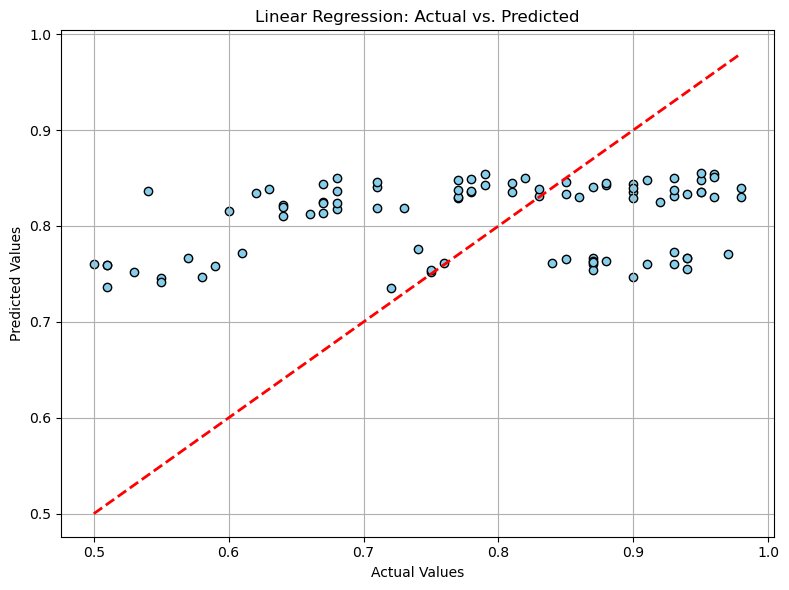

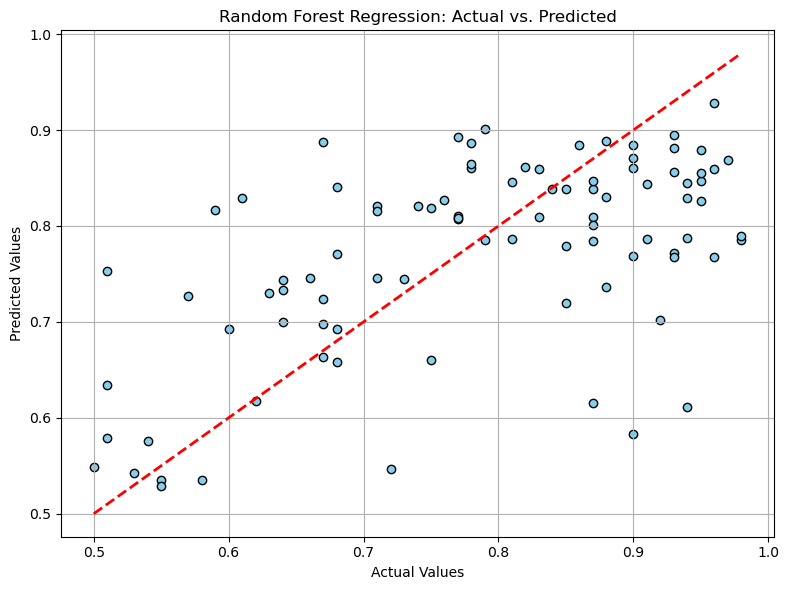

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


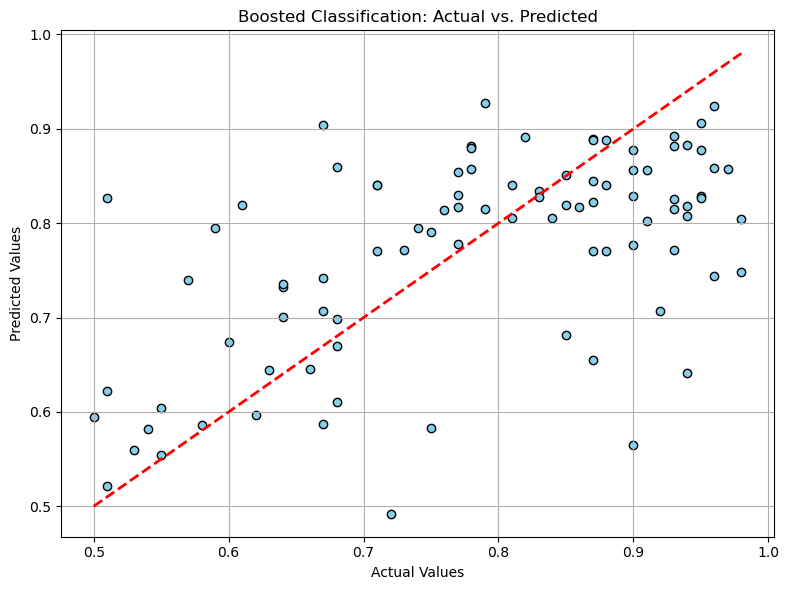

In [286]:
# 1. Linear regression 
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)
y_pred_linear = linear_model.predict(X_test_scaled)
# Plot Actual vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, y_pred_linear, color='skyblue', edgecolor='k')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)  # 45-degree line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression: Actual vs. Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Random forset 
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, Y_train.values.ravel())
y_pred_rf = rf_model.predict(X_test_scaled)
# Plot Actual vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, y_pred_rf, color='skyblue', edgecolor='k')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)  # 45-degree line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regression: Actual vs. Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Boosted classification 
gbr = GradientBoostingRegressor(n_estimators=100, max_depth = 3, random_state=123) # Set 1000 trees of max 3 in depth
gbr.fit(X_train_scaled, Y_train)
y_pred_boosted = gbr.predict(X_test_scaled)
# Plot Actual vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, y_pred_boosted, color='skyblue', edgecolor='k')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)  # 45-degree line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Boosted Classification: Actual vs. Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()


In [287]:
# Compare MSEs of the well performing models 
mse_linear = mean_squared_error(Y_test, y_pred_linear)
mse_rf = mean_squared_error(Y_test, y_pred_rf)
mse_boosted = mean_squared_error(Y_test, y_pred_boosted)
mse_bagging = mean_squared_error(Y_test, y_pred_bagging)
print(f"Linear Regression MSE         : {mse_linear:.4f}")
print(f"Random Forest Regression MSE : {mse_rf:.4f}")
print(f"Boosted Regression MSE       : {mse_boosted:.4f}")
# Compare R values
r2_linear = r2_score(Y_test, y_pred_linear)
r2_rf = r2_score(Y_test, y_pred_rf)
r2_boosted = r2_score(Y_test, y_pred_boosted)
r2_lasso = r2_score(Y_test, y_pred_lasso)
print(f"Linear Regression R²         : {r2_linear:.4f}")
print(f"Random Forest Regression R² : {r2_rf:.4f}")
print(f"Boosted Regression R²       : {r2_boosted:.4f}")

Linear Regression MSE         : 0.0180
Random Forest Regression MSE : 0.0130
Boosted Regression MSE       : 0.0136
Linear Regression R²         : 0.0492
Random Forest Regression R² : 0.3099
Boosted Regression R²       : 0.2788


## Step 6: Investigating prediction quality using sleep metrics

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


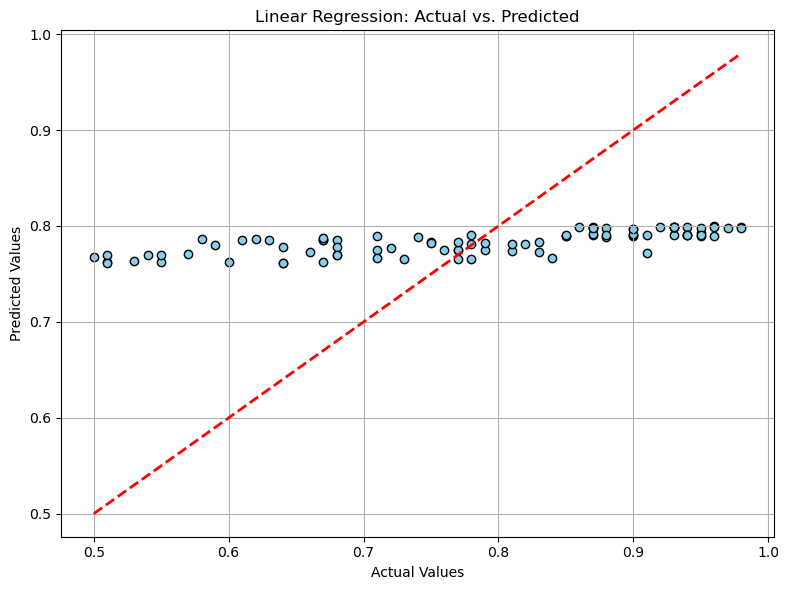

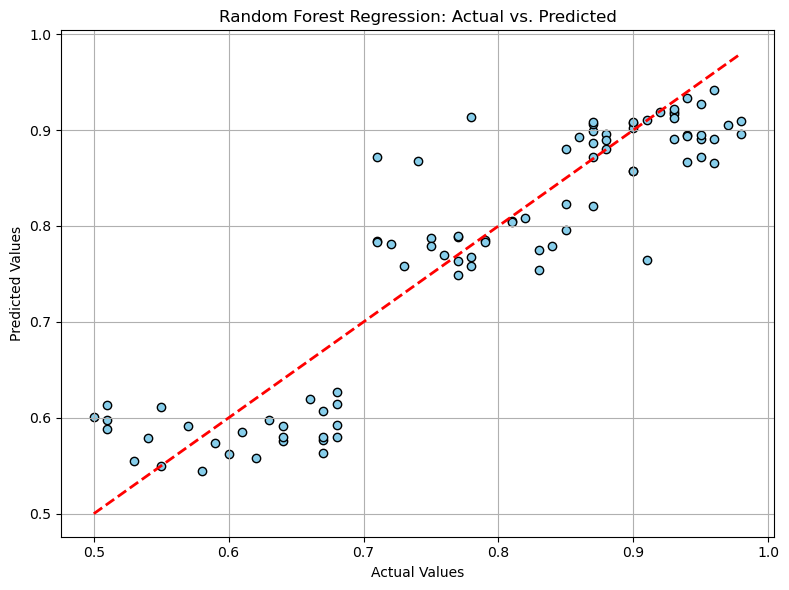

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


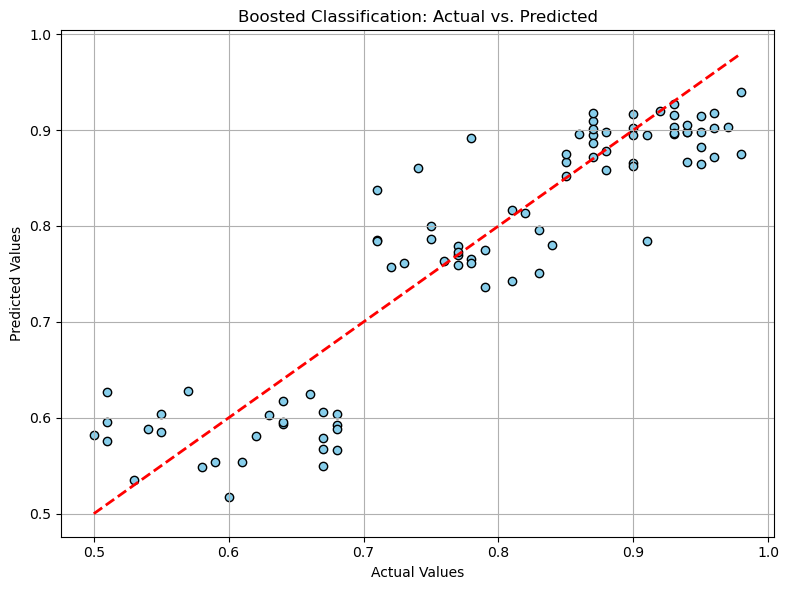

In [198]:
# Drop non-lifestyle variables
sleepy_data = sleep_data_imputed.drop(['Age','Gender','Bedtime','Wakeup time', 'Caffeine consumption', 'Alcohol consumption','Smoking status','Exercise frequency'], axis=1)

# Define X and Y
outcome=['Sleep efficiency']
X=sleepy_data.drop(outcome, axis='columns')
Y=sleepy_data[outcome]

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=3897)

scalar=MinMaxScaler()
X_train_scaled=scalar.fit_transform(X_train)
X_test_scaled=scalar.transform(X_test)

# 1. Linear regression 
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)
y_pred_linear = linear_model.predict(X_test_scaled)
# Plot Actual vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, y_pred_linear, color='skyblue', edgecolor='k')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)  # 45-degree line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression: Actual vs. Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Random forset 
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, Y_train.values.ravel())
y_pred_rf = rf_model.predict(X_test_scaled)
# Plot Actual vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, y_pred_rf, color='skyblue', edgecolor='k')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)  # 45-degree line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regression: Actual vs. Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Boosted classification 
gbr = GradientBoostingRegressor(n_estimators=100, max_depth = 3, random_state=123) # Set 1000 trees of max 3 in depth
gbr.fit(X_train_scaled, Y_train)
y_pred_boosted = gbr.predict(X_test_scaled)
# Plot Actual vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, y_pred_boosted, color='skyblue', edgecolor='k')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)  # 45-degree line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Boosted Classification: Actual vs. Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()



In [200]:
# Compare MSEs of models 
mse_linear = mean_squared_error(Y_test, y_pred_linear)
mse_rf = mean_squared_error(Y_test, y_pred_rf)
mse_boosted = mean_squared_error(Y_test, y_pred_boosted)
mse_bagging = mean_squared_error(Y_test, y_pred_bagging)
print(f"Linear Regression MSE         : {mse_linear:.4f}")
print(f"Random Forest Regression MSE : {mse_rf:.4f}")
print(f"Boosted Regression MSE       : {mse_boosted:.4f}")
# Compare R values
r2_linear = r2_score(Y_test, y_pred_linear)
r2_rf = r2_score(Y_test, y_pred_rf)
r2_boosted = r2_score(Y_test, y_pred_boosted)
r2_lasso = r2_score(Y_test, y_pred_lasso)
print(f"Linear Regression R²         : {r2_linear:.4f}")
print(f"Random Forest Regression R² : {r2_rf:.4f}")
print(f"Boosted Regression R²       : {r2_boosted:.4f}")

Linear Regression MSE         : 0.0165
Random Forest Regression MSE : 0.0033
Boosted Regression MSE       : 0.0033
Linear Regression R²         : 0.1235
Random Forest Regression R² : 0.8234
Boosted Regression R²       : 0.8247


## Conclusion 
We can see that lifestyle factors alone are not great at predicting sleep efficiency. However, if we have access to sleep metrics, we are much better able to predict sleep efficiency. Whilst linear regression is not a great fit for the prediction, random forest and boosted regression are able to predict sleep efficiency quite well. 